In [ ]:
!uv pip install jupyterlab-vim
!pip install jupyterlab-vim

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import tifffile
import mbo_utilities as mbo
import fastplotlib as fpl

# import dask.array as da

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [5]:
tiff_path = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled\plane_01_mk301.tiff"

out_file = "./out.bin"
fname = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled"

In [15]:
files = mbo.get_files(fname, 'tif', 1)
files

['D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_01_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_02_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_03_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_04_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_05_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_06_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_07_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_08_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_09_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_10_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_11_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_12_mk301.tiff',
 'D:\\W2_DATA\\kbarber\\2025_03_01\\mk301\\assembled\\plane_13_mk301.tiff',
 'D:\\W2_DAT

In [16]:
data = tifffile.memmap(files[6])

In [22]:
fig = fpl.Figure()
volume = fig[0,0].add_image_volume(data=data[:500])

# volume.interpolation = "linear"
volume.cmap = "gnuplot2"

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
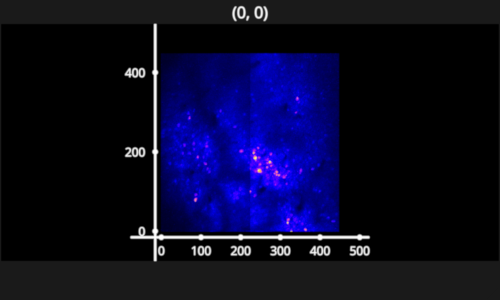

In [23]:
fig.show()

In [25]:
fig.close()

In [9]:
fname_scan = r"D:\W2_DATA\kbarber\2025_03_01\mk301\green\*"
raw_scan = mbo.read_scan(fname_scan)

Detected possible escaped characters in the path. Use a raw string (r'...') or double backslashes.


In [52]:
mbo.save_as(raw_scan, r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr", planes=[0, 7, 13], ext=".zarr")

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.


Saving plane 1:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 8:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216


Saving plane 14:   0%|          | 0/216 [00:00<?, ?it/s]

num-chunks: 216
Time elapsed: 0 minutes 33 seconds.


In [55]:
zpath = r"D:\W2_DATA\kbarber\2025_03_01\mk301\assembled_zarr"
arr = mbo.zarr_to_dask(zpath)

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
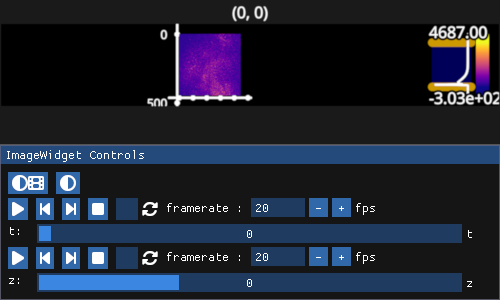

In [56]:
iw = fpl.ImageWidget(arr)
iw.show()

In [118]:
from __future__ import annotations

import os
import re
from collections.abc import Sequence
from itertools import product
from pathlib import Path

import dask.array as da
import ffmpeg
import numpy as np
import tifffile
from matplotlib import cm

from mbo_utilities.scanreader import scans
from mbo_utilities.scanreader.multiroi import ROI
from mbo_utilities.util import norm_minmax, subsample_array

class MBO_Scan(scans.ScanMultiROI):
    """
    A subclass of ScanMultiROI that ignores the num_fields dimension
    and reorders the output to [time, z, x, y].
    """
    def __getitem__(self, key):
        """Index like a 4D numpy array [t, z, x, y]"""
        if key == slice(None):
            return subsample_array(self, ignore_dims=[-1, -2, -3])
        elif not isinstance(key, tuple):
            key = (key,)

        t_key, z_key, x_key, y_key = key + (slice(None),) * (4 - len(key))
        reordered_key = (0, y_key, x_key, z_key, t_key)
        item = super().__getitem__(reordered_key)
        ndim = item.ndim
        if ndim == 2:
            return item[np.newaxis, np.newaxis, :, :]  # (1,1,x,y)
        if ndim == 3:
            return np.transpose(item, (2, 0, 1))[np.newaxis]  # (1,z,x,y)
        if ndim == 4:
            return np.transpose(item, (3, 2, 0, 1))  # (t,z,x,y)
        raise ValueError(f"Unexpected ndim: {ndim}")

    # @property
    # def min(self):
    #     """
    #     Returns the minimum value of the first tiff page.
    #     """
    #     page = super().__getitem__((0, slice(None), slice(None), 0, 0))
    #     return np.min(page)

    # @property
    # def max(self):
    #     """
    #     Returns the maximum value of the first tiff page.
    #     """
    #     page = super().__getitem__((0, slice(None), slice(None), 0, 0))
    #     return np.max(page)

    @property
    def shape(self):
        return (
            self.num_frames,
            self.num_channels,
            self.field_heights[0],
            self.field_widths[0],
        )

    @property
    def ndim(self):
        return 4

    @property
    def size(self):
        return (
            self.num_frames
            * self.num_channels
            * self.field_heights[0]
            * self.field_widths[0]
        )

    @property
    def scanning_depths(self):
        """
        We override this because LBM should always be at a single scanning depth.
        """
        return [0]

    def _create_rois(self):
        """
        Create scan rois from the configuration file. Override the base method to force
        ROI's that have multiple 'zs' to a single depth.
        """
        try:
            roi_infos = self.tiff_files[0].scanimage_metadata["RoiGroups"][
                "imagingRoiGroup"
            ]["rois"]
        except KeyError:
            raise RuntimeError(
                "This file is not a raw-scanimage tiff or is missing tiff.scanimage_metadata."
            )
        roi_infos = roi_infos if isinstance(roi_infos, list) else [roi_infos]
        roi_infos = list(
            filter(lambda r: isinstance(r["zs"], (int, float, list)), roi_infos)
        )  # discard empty/malformed ROIs
        for roi_info in roi_infos:
            # LBM uses a single depth that is not stored in metadata, so force this to be 0
            roi_info["zs"] = [0]

        rois = [ROI(roi_info) for roi_info in roi_infos]
        return rois

class MBO_Scan(scans.ScanMultiROI):
    """
    A subclass of ScanMultiROI that ignores the num_fields dimension
    and reorders the output to [time, z, x, y].
    """
    def __getitem__(self, key):
        """Index like a 4D numpy array [t, z, x, y]"""
        if key == slice(None):
            return subsample_array(self, ignore_dims=[-1, -2, -3])
        elif not isinstance(key, tuple):
            key = (key,)

        t_key, z_key, x_key, y_key = key + (slice(None),) * (4 - len(key))
        reordered_key = (0, y_key, x_key, z_key, t_key)
        item = super().__getitem__(reordered_key)
        ndim = item.ndim
        if ndim == 2:
            return item[np.newaxis, np.newaxis, :, :]  # (1,1,x,y)
        if ndim == 3:
            return np.transpose(item, (2, 0, 1))[np.newaxis]  # (1,z,x,y)
        if ndim == 4:
            return np.transpose(item, (3, 2, 0, 1))  # (t,z,x,y)
        raise ValueError(f"Unexpected ndim: {ndim}")

    @property
    def min(self):
        """
        Returns the minimum value of the first tiff page.
        """
        page = super().__getitem__((0, slice(None), slice(None), 0, 0))
        return np.min(page)

    @property
    def max(self):
        """
        Returns the maximum value of the first tiff page.
        """
        page = super().__getitem__((0, slice(None), slice(None), 0, 0))
        return np.max(page)

    @property
    def shape(self):
        return (
            self.num_frames,
            self.num_channels,
            self.field_heights[0],
            self.field_widths[0],
        )

    @property
    def ndim(self):
        return 4

    @property
    def size(self):
        return (
            self.num_frames
            * self.num_channels
            * self.field_heights[0]
            * self.field_widths[0]
        )

    @property
    def scanning_depths(self):
        """
        We override this because LBM should always be at a single scanning depth.
        """
        return [0]

    def _create_rois(self):
        """
        Create scan rois from the configuration file. Override the base method to force
        ROI's that have multiple 'zs' to a single depth.
        """
        try:
            roi_infos = self.tiff_files[0].scanimage_metadata["RoiGroups"][
                "imagingRoiGroup"
            ]["rois"]
        except KeyError:
            raise RuntimeError(
                "This file is not a raw-scanimage tiff or is missing tiff.scanimage_metadata."
            )
        roi_infos = roi_infos if isinstance(roi_infos, list) else [roi_infos]
        roi_infos = list(
            filter(lambda r: isinstance(r["zs"], (int, float, list)), roi_infos)
        )  # discard empty/malformed ROIs
        for roi_info in roi_infos:
            # LBM uses a single depth that is not stored in metadata, so force this to be 0
            roi_info["zs"] = [0]

        rois = [ROI(roi_info) for roi_info in roi_infos]
        return rois

In [107]:
pathnames = r"D:\demo\raw_data/*"
filenames = mbo.expand_paths(pathnames)

In [108]:
scan = MBO_Scan(join_contiguous=True)
scan.read_data(filenames, dtype=np.int16)

In [119]:
scan = mbo.read_scan(filenames)

In [109]:
scan.shape

(1437, 14, 448, 448)

In [111]:
scan[0, 0, :, :]

array([[[[-24, -22, -18, ..., 113, 143, -26],
         [182, -23, -23, ..., -18,  87, -13],
         [-24, -33, -17, ..., 451, 305, 475],
         ...,
         [206, -27, -29, ..., 101, 387,  -8],
         [ -9, 234,  -4, ..., 678, 273, 272],
         [-15, -19, -14, ..., 204, -11,  88]]]], dtype=int16)

In [116]:
scan.min, scan.max

(-169, 4381)

In [112]:
scan[:].shape

(206, 14, 448, 448)

In [113]:
import napari

In [114]:
viewer = napari.Viewer()
viewer.add_image(scan[:])

<Image layer 'Image' at 0x16f0e6c7690>

In [83]:
def subsample_array(
    arr, max_size: int = int(1e6), ignore_dims: Sequence[int] | None = None
):
    if np.prod(arr.shape, dtype=np.int64) <= max_size:
        return arr[:]

    f = np.power((np.prod(arr.shape, dtype=np.int64) / max_size), 1.0 / arr.ndim)

    ns = np.floor(np.array(arr.shape, np.int64) / f).clip(min=1)

    step_sizes = np.floor(arr.shape / ns).astype(int)

    slices = [slice(None, None, step) for step in step_sizes]

    if ignore_dims is not None:
        for dim in ignore_dims:
            slices[dim] = slice(None)

    return np.asarray(arr[tuple(slices)])

In [87]:
subsample_array(scan, ignore_dims=[-1, -2]).shape

(206, 1, 448, 448)

Fetching MillerBrainObservatory/mbo_utilities...
Fetching MillerBrainObservatory/LBM-Suite2p-Python...
Fetching MillerBrainObservatory/millerbrainobservatory.github.io...


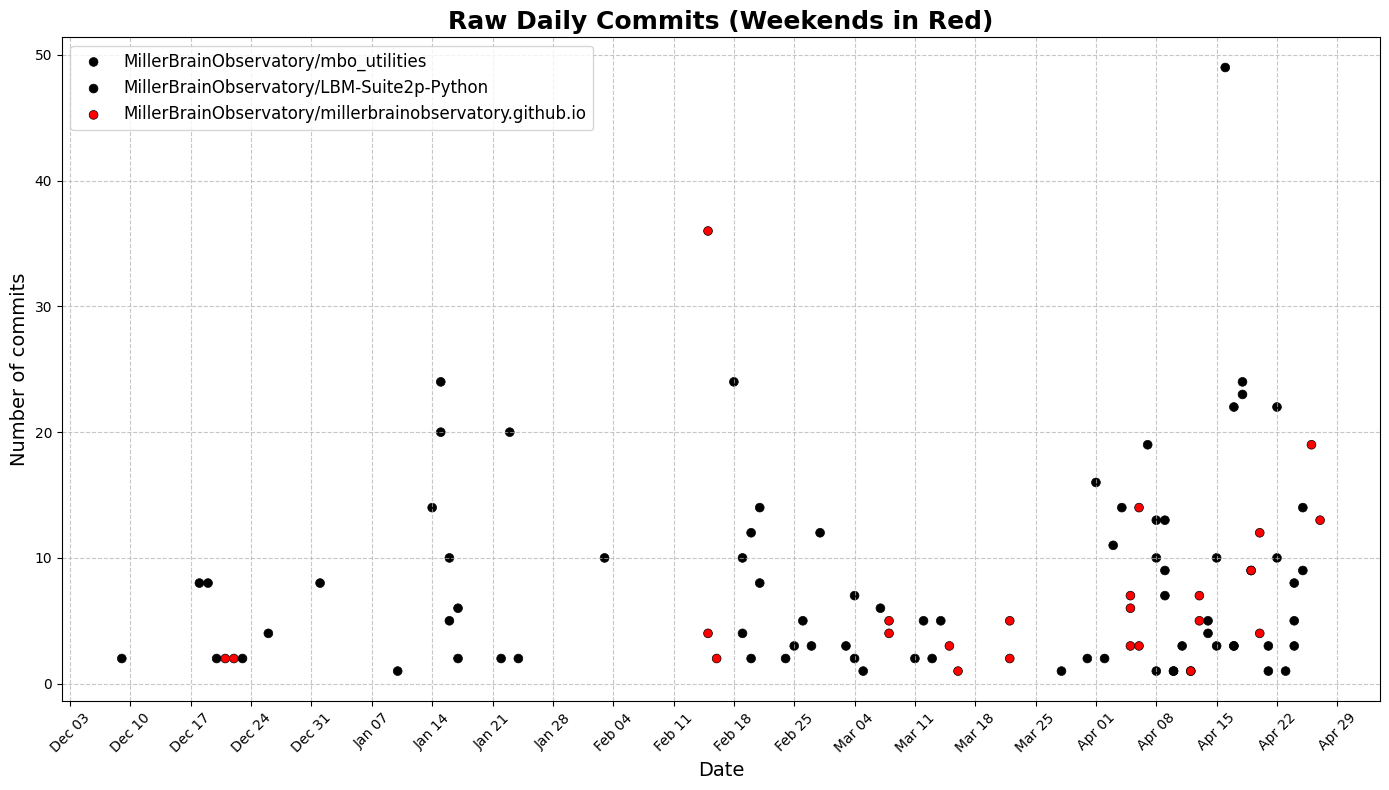

In [69]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# List of public repos (format: "owner/repo")
REPOS = [
    "MillerBrainObservatory/mbo_utilities",
    "MillerBrainObservatory/LBM-Suite2p-Python",
    "MillerBrainObservatory/millerbrainobservatory.github.io",
]

API_URL_TEMPLATE = "https://api.github.com/repos/{repo}/commits"

def fetch_commits(repo, since="2024-12-01"):
    commits = []
    page = 1
    while True:
        url = API_URL_TEMPLATE.format(repo=repo)
        params = {"since": since, "per_page": 100, "page": page}
        response = requests.get(url, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        commits.extend([commit["commit"]["author"]["date"] for commit in data])
        page += 1
    return pd.to_datetime(commits)

def main():
    fig, ax = plt.subplots(figsize=(14, 8))

    for repo in REPOS:
        print(f"Fetching {repo}...")
        commit_dates = fetch_commits(repo)
        if commit_dates.empty:
            continue
        commits_per_day = commit_dates.normalize().value_counts().sort_index()

        # Color weekends differently
        colors = ['red' if date.weekday() >= 5 else 'black' for date in commits_per_day.index]

        ax.scatter(
            commits_per_day.index,
            commits_per_day.values,
            label=repo,
            c=colors,
            marker='o',
            s=40,
            edgecolors='k',
            linewidths=0.5,
        )

    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("Number of commits", fontsize=14)
    ax.set_title("Raw Daily Commits (Weekends in Red)", fontsize=18, weight="bold")
    ax.legend(fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()